In [17]:
# %pip install scipy
# %pip install beautifulsoup4
# %pip install tenacity
# %pip install yfinance --upgrade --no-cache-dir 
# %pip uninstall yfinance -y 
# %pip install ratelimit
%pip install python-dotenv


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:

import config as cfg
import bs4 as bs
import concurrent
import datetime
import importlib
import json
import logging
import modelling_prep as mp
import os
import pandas as pd
import pickle
from plotly.subplots import make_subplots
import numpy as np
import requests
import tenacity as tnc

importlib.reload(cfg)
importlib.reload(mp)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

if not os.path.exists('logs'):
    os.makedirs('logs')
filename = f"logs/{__name__}_{datetime.datetime.now().strftime('%Y-%m-%d-%H')}.log"
if not os.path.exists(filename):
    with open(filename, 'wt') as f:
        f.write(f'*** {filename} ***\n') 
        
if len(logger.handlers) < 1:
    handler = logging.FileHandler(filename)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

config_path = "config"
# config_file = "debug.json"
# config_file = "debug_dual_forecast_out.json"
# config_file = "debug_dual_forecast_out_6_months.json"
# config_file = "daily_run.json"
config_file = "backtest_2021.json"
# config_file = "backtest_2022.json"
# config_file = "backtest_2023.json"
# config_file = "daily_run_backtest_2023.json"
# config_file = "daily_run.json"

try:
    conf = cfg.load_config(config_path, config_file)
except json.JSONDecodeError as e:
    logger.error(f"Error loading JSON file: {config_file}. {e}")

2024-02-20 22:11:15,553 - config - INFO - loading config at path config\backtest_2021.json


In [3]:


forecast_col = 'adjClose'

start = conf.start_date # datetime.datetime(2018, 1, 1)
# end = datetime.datetime(2023, 12, 31)
end = conf.end_date # datetime.datetime.now()
current_date = datetime.datetime.now().strftime('%Y-%m-%d')
data_path = conf.data_path # os.path.join(os.getcwd(), "data", current_date)  
logger.info(f"data_path: {data_path}")

# algo portfolio
tickers = set(conf.tickers)

ignore_tickers = set([
  'BRK.B',
  'BF.B',
  'DAY',
  'ROK',
  'BMYKT',
])


if conf.add_snp_500:
  headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17'}
  resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies',
                      headers=headers)
  soup = bs.BeautifulSoup(resp.text, 'lxml')
  table = soup.find('table', {'class': 'wikitable sortable'})
  for row in table.findAll('tr')[1:]:
          ticker = row.findAll('td')[0].text.strip()
          if ticker not in ignore_tickers:
            tickers.add(ticker)
          
for ticker in ignore_tickers:
  if ticker in tickers:
    tickers.remove(ticker)
# tickers


2024-02-20 22:11:15,672 - __main__ - INFO - data_path: data\2024-02-16


'Aw4HU49x1ktoouk2qz8sxClJniOyuJoC'

In [4]:

import importlib
import modelling_prep as mp
importlib.reload(mp)


# Ensure that the data_path directory exists
os.makedirs(data_path, exist_ok=True)

pickle_file_name = os.path.join(conf.feature_path, "features_df.pkl")
force = False

if not force and os.path.exists(pickle_file_name):
    logger.debug(f"Loading {pickle_file_name}")
    with open(pickle_file_name, 'rb') as file:
        features_df = pickle.load(file)
else:
    dfs = []
    from datetime import timedelta
    
    max_errors = 5

    @tnc.retry(stop=tnc.stop_after_attempt(7), wait=tnc.wait_exponential(multiplier=1, min=2, max=5))
    def add_if_df(stock_ticker): 
        return mp.create_financials_df(stock_ticker, data_path, start, end)
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        results = executor.map(add_if_df, tickers) 
        for result in results:
            logger.debug(f"result: {result}")
            if results is not None:
                # display(result)
                dfs.append(result) 
            else:
                logger.error(f"failure to get financials for a ticker Skipping.")
                max_errors -= 1
                if max_errors <= 0:
                    logger.error(f"Too many errors.  Exiting.")
                    raise Exception("Too many errors.  Exiting.")
        features_df = pd.concat(dfs)

    os.makedirs(conf.feature_path)
    with open(pickle_file_name, 'wb') as file:
        pickle.dump(features_df, file)
        


In [5]:
# display(features_df)
# display(features_df.dropna())
# multi_count_df = features_df.reset_index().groupby(['symbol', 'date'])['date'].count()
# multi_count_df = multi_count_df[multi_count_df > 1]
# multi_count_df

In [6]:
multi_count_df = features_df.reset_index().groupby(['symbol', 'date'])['date'].count()
multi_count_df = multi_count_df[multi_count_df > 1]
multi_count_df

Series([], Name: date, dtype: int64)

In [7]:
# reset the index, change the 'date' column to datetime from object type, rename 'date' column to 'Date', and set the index to the 'date' and 'symbol' columns 
features_other_df = features_df.copy(deep=True).reset_index() # .rename(columns={'date': 'Date'})
# .set_axis(['symbol', 'date'])
# .rename_axis(None, axis=1)
features_other_df['date'] = pd.to_datetime(features_other_df['date'])
features_other_df = features_other_df.set_index(['date', 'symbol'])

features_other_df = features_other_df.ffill()
for col in features_other_df.columns: 
    # logger.info(f"col: {col} df_combined[col].dtype: {df_combined[col].dtype}")
    if col.startswith('grade') or col.startswith('grading'):
        # features_other_df[col] = features_other_df[col].ffill()
        features_other_df[col] = features_other_df[col].fillna(999999)
    else:
        features_other_df[col] = features_other_df[col].fillna(0)
        
features_df = None
# features_other_df


In [8]:


def add_ichimoku_data_to_df(df):
    
    # Calculate the Ichimoku Cloud indicators
    # Tenkan-sen (Conversion Line): (9-period high + 9-period low) / 2
    nine_period_high = df['high'].rolling(window=9).max()
    nine_period_low = df['low'].rolling(window=9).min()
    df['conversion'] = (nine_period_high + nine_period_low) / 2

    # Kijun-sen (Base Line): (26-period high + 26-period low) / 2
    twenty_six_period_high = df['high'].rolling(window=26).max()
    twenty_six_period_low = df['low'].rolling(window=26).min()
    df['baseline'] = (twenty_six_period_high + twenty_six_period_low) / 2

    # Senkou Span A (Leading Span A): (Conversion Line + Base Line) / 2
    df['spanA'] = ((df['conversion'] + df['baseline']) / 2)#.iftift(26)

    # Senkou Span B (Leading Span B): (52-period high + 52-period low) / 2
    fifty_two_period_high = df['high'].rolling(window=52).max()
    fifty_two_period_low = df['low'].rolling(window=52).min()
    df['spanB'] = ((fifty_two_period_high + fifty_two_period_low) / 2)#.shift(26)

    # Chikou Span (Lagging Span): Close shifted 26 periods into the past
    df['lagging_span'] = df['adjClose'].shift(26)

    return df

ichimoku_features_df = features_other_df.copy(deep=True)
features_other_df = None
ichimoku_features_df = ichimoku_features_df.groupby(by='symbol',group_keys=False).apply(add_ichimoku_data_to_df)
ichimoku_features_df = ichimoku_features_df.reset_index()
ichimoku_features_df['date'] = pd.to_datetime(ichimoku_features_df['date'])
ichimoku_features_df = ichimoku_features_df.set_index(['date', 'symbol'])
ichimoku_features_df

,,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,...,gradingCompany_newGrade_Swedbank,gradingCompany_newGrade_Midtown_Partners,gradingCompany_newGrade_SBG_Securities,gradingCompany_newGrade_GARP_Research,gradingCompany_newGrade_DBS_Bank,conversion,baseline,spanA,spanB,lagging_span
date,symbol,,,,,,,,,,,,,,,,,,,,,
1987-03-31,SCHW,0.00,0.000,0.000,0.00,0.00,0.0,0.0,0.00,0.00000,0.00,...,999999.0,999999.0,999999.0,999999.0,999999.0,NaN,NaN,NaN,NaN,NaN
1988-03-31,SCHW,0.00,0.000,0.000,0.00,0.00,0.0,0.0,0.00,0.00000,0.00,...,999999.0,999999.0,999999.0,999999.0,999999.0,NaN,NaN,NaN,NaN,NaN
1989-03-31,SCHW,0.00,0.000,0.000,0.00,0.00,0.0,0.0,0.00,0.00000,0.00,...,999999.0,999999.0,999999.0,999999.0,999999.0,NaN,NaN,NaN,NaN,NaN
1989-05-25,SCHW,0.00,0.000,0.000,0.00,0.00,0.0,0.0,0.00,0.00000,0.00,...,999999.0,999999.0,999999.0,999999.0,999999.0,NaN,NaN,NaN,NaN,NaN
1989-07-26,SCHW,0.00,0.000,0.000,0.00,0.00,0.0,0.0,0.00,0.00000,0.00,...,999999.0,999999.0,999999.0,999999.0,999999.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-12,NEE,56.59,57.630,56.500,57.55,57.55,9622014.0,9622000.0,0.96,1.70000,57.36,...,3.0,3.0,3.0,1.0,3.0,57.6825,59.2200,58.45125,59.9875,61.80
2024-02-13,NEE,56.88,57.140,54.665,55.25,55.25,12759748.0,12759700.0,-1.63,-2.87000,55.25,...,3.0,3.0,3.0,1.0,3.0,57.2475,58.8600,58.05375,59.6275,62.08
2024-02-14,NEE,55.39,56.065,55.090,56.01,56.01,8831274.0,8831300.0,0.62,1.12000,55.71,...,3.0,3.0,3.0,1.0,3.0,56.8475,58.8525,57.85000,59.6275,62.92


In [9]:

# ichimoku_features_df = pd.merge(ichimoku_df, features_other_df, on=['Date','symbol'], how='left')
# ichimoku_features_df = ichimoku_df

# display(ichimoku_df.dropna())
# display(features_other_df.dropna())
# display(ichimoku_features_df.dropna())



In [10]:
def add_price_features(df):

    df['Market Cap'] = df['weightedAverageShsOut'].ffill() * df['adjClose']
    df['Price to Book'] = df['Market Cap'] / df['totalStockholdersEquity'].ffill() 
    # df['EPS TTM'] = df['eps'].rolling(4, min_periods=4).sum()
    # df['EPS TTM'] = df['eps']
    df['EPS TTM'] = df['eps'].fillna(df['eps'].rolling(4, min_periods=4).sum())
    df['EPS TTM'].ffill(inplace=True)
    df['P/E TTM'] = df['adjClose'].ffill() / df['EPS TTM'].ffill()
    df['P/E TTM']  = df['P/E TTM'].clip(upper=100, lower=1)
    df['log(P/E TTM)'] = np.log(df['P/E TTM'])
    df['eps'] = df['eps'].fillna(0)
    # for x in range(1, 20):
    #     df[f'EPS_{x}'] = df['eps'].shift(x)
    for x in range(1, 4):
        col_name = f'EPS_{2**x}_trailing_mean'
        df[col_name] = df['eps'].rolling(2**x, min_periods=1).mean()
        # df[col_name] = df[col_name].fillna(0)
    # remove outliers
    # calculate IQR for column Height
    # Q1 = df['P/E TTM'].quantile(0.25)
    # Q3 = df['P/E TTM'].quantile(0.75)
    # IQR = Q3 - Q1

    # # identify outliers
    # threshold = 1.5
    # outliers = df[(df['Height'] < Q1 - threshold * IQR) | (df['Height'] > Q3 + threshold * IQR)]
    return df
# ichimoku_price_features_df['EPS TTM'].notna() 
ichimoku_price_features_df = ichimoku_features_df.groupby(by='symbol', group_keys=False).apply(add_price_features).sort_index()
ichimoku_price_features_df = ichimoku_price_features_df.loc[
    (datetime.datetime.now() >= ichimoku_price_features_df.index.get_level_values('date')) &
    (ichimoku_price_features_df.index.get_level_values('date') > '2019-01-01')
    ]
# ichimoku_price_features_df.sort_index()[['EPS_4_trailing_mean', 'weightedAverageShsOut', 'Close', 'Market Cap','Price to Book', 'eps', 'P/E TTM', 'EPS TTM', 'log(P/E TTM)']]
ichimoku_price_features_df


open     high       low   close  adjClose     volume  \
date       symbol                                                           
2019-01-02 AAPL    659.27  660.470  648.7100  650.31    650.31   366541.0   
           ABBV     77.58   78.220   76.5600   77.70     77.70  2494691.0   
           AEP     106.47  108.290  105.8950  108.22    108.22  2949161.0   
           ALB     220.60  221.505  217.2450  219.04    219.04   221448.0   
           BIO      82.48   83.185   82.1500   82.61     82.61   874867.0   
...                   ...      ...       ...     ...       ...        ...   
2024-02-20 MRO      23.30   23.550   22.4850   23.38     23.38  8753883.0   
           ROL      41.71   41.990   40.4100   41.05     41.05  3803998.0   
           TGT     145.73  150.290  145.1257  149.61    149.61  4350873.0   
           XYL     124.26  124.750  123.5000  123.79    123.79  1205372.0   
           YUM     135.23  135.845  134.3950  134.55    134.55  2519474.0   

                   unadjustedVolume  change  changePercent    vwap  ...  \
date       symbol                                                   ...   
2019-01-02 AAPL            366345.0   -8.96       -1.36000  653.94  ...   
           ABBV           1988566.0    0.12        0.15468   77.71  ...   
           AEP            2949373.0    1.75        1.64000  107.65  ...   
           ALB             215492.0   -1.56       -0.70716  219.41  ...   
           BIO             803946.0    0.13        0.15761   82.80  ...   
...                             ...     ...            ...     ...  ...   
2024-02-20 MRO            8709318.0    0.08        0.34335   23.35  ...   
           ROL            3412467.0   -0.66       -1.58000   41.07  ...   
           TGT            3666396.0    3.88        2.66000  148.96  ...   
           XYL            1028481.0   -0.47       -0.37824  124.18  ...   
           YUM            2461495.0   -0.68       -0.50285  135.00  ...   

                      spanB  lagging_span    Market Cap  Price to Book  \
date       symbol                                                        
2019-01-02 AAPL    654.5900        650.31  1.231900e+13     104.493981   
           ABBV     77.3900         77.70  1.162392e+11     -13.762633   
           AEP     107.0925        108.22  5.338591e+10       2.805591   
           ALB     219.3750        219.04  2.322744e+10       6.478483   
           BIO      82.6675         82.61  2.468222e+09       0.614639   
...                     ...           ...           ...            ...   
2024-02-20 MRO      23.5550         22.94  1.416097e+10       1.261444   
           ROL      42.4200         43.85  1.986500e+10      17.190693   
           TGT     141.3450        142.02  6.905998e+10       5.518617   
           XYL     114.9750        111.67  2.981358e+10       3.002375   
           YUM     129.7725        129.00  3.784636e+10      -4.621045   

                   EPS TTM     P/E TTM  log(P/E TTM)  EPS_2_trailing_mean  \
date       symbol                                                           
2019-01-02 AAPL       1.06  100.000000      4.605170                 1.06   
           ABBV      -1.23    1.000000      0.000000                -1.23   
           AEP        0.74  100.000000      4.605170                 0.74   
           ALB        1.22  100.000000      4.605170                 1.22   
           BIO      -27.88    1.000000      0.000000               -27.88   
...                    ...         ...           ...                  ...   
2024-02-20 MRO        0.75   31.173333      3.439563                 0.75   
           ROL        0.22  100.000000      4.605170                 0.22   
           TGT        2.10   71.242857      4.266095                 2.10   
           XYL        0.63  100.000000      4.605170                 0.63   
           YUM        1.48   90.912162      4.509894                 1.48   

                   EPS_4_trailing_mean  EPS_8_trailing_mean  
date       symbo

In [11]:
if not os.path.exists(conf.feature_path):
    os.makedirs(conf.feature_path)
filename = os.path.join(conf.feature_path, 'ichimoku_price_features_df.pkl')
with open(filename, 'wb') as file:
    logger.info(f"writing features to: {filename}")
    pickle.dump(ichimoku_price_features_df, file)
# ichimoku_price_features_df.to_csv('ichimoku_price_features_df.csv')

2024-02-20 22:12:55,514 - __main__ - INFO - writing features to: features/backtest/2021\2024-02-16\ichimoku_price_features_df.pkl


0
gradingCompany_newGrade_Empire_Asset_Management gradingCompany_newGrade_Shore_Capital            9.799796e-01
gradingCompany_newGrade_Shore_Capital           gradingCompany_newGrade_Empire_Asset_Management  9.799796e-01
gradingCompany_newGrade_Empire_Asset_Management gradingCompany_newGrade_Charles_Stanley          9.799796e-01
gradingCompany_newGrade_Charles_Stanley         gradingCompany_newGrade_Empire_Asset_Management  9.799796e-01
gradingCompany_newGrade_Natixis                 gradingCompany_newGrade_Empire_Asset_Management  9.799796e-01
...                                                                                                       ...
debtRepayment                                   gradingCompany_newGrade_Macquarie                1.154847e-07
gradingCompany_newGrade_Mizuho                  debtRepayment                                    7.406013e-08
debtRepayment                                   gradingCompany_newGrade_Mizuho                   7.406013e-08
                                                gradingCompany_newGrade_BTIG_Research            2.959238e-08
gradingCompany_newGrade_BTIG_Research           debtRepayment                                    2.959238e-08

[226868 rows x 1 columns]

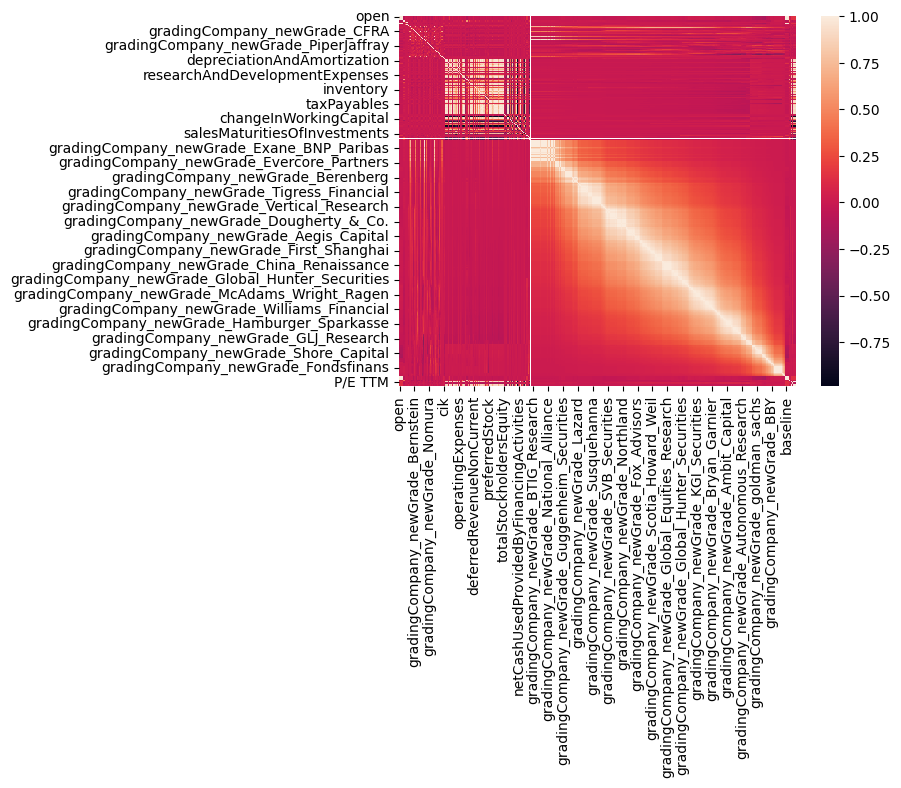

In [12]:


import seaborn as sns
# %matplotlib inline

# load the Auto dataset
# auto_df = sns.load_dataset('mpg')

# calculate the correlation matrix on the numeric columns
corr = ichimoku_price_features_df.dropna().select_dtypes('number').corr()
corr_abs = corr.abs()
unstacked = corr_abs.unstack()
sorted_pairs = unstacked.sort_values(kind="quicksort")
sorted_pairs_df = pd.DataFrame(sorted_pairs)
# logger.info(f"correlation pairs: {sorted_pairs}")
# plot the heatmap
sns.heatmap(corr)
sorted_pairs_df = sorted_pairs_df[sorted_pairs_df[0] < 0.98].sort_values(by=0, ascending=False)
# sorted_pairs_df.to_csv('correlation_pairs.csv')
# sorted_pairs_df.columns = ['feature_1', 'feature_2', 'corr']
sorted_pairs_df


In [13]:

# import sklearn_util as sklu
# import importlib
# importlib.reload(sklu)

saved_series = ichimoku_price_features_df[forecast_col]
ichimoku_price_features_numeric_df = ichimoku_price_features_df.drop(forecast_col, axis=1).select_dtypes(include='number')
ichimoku_price_features_numeric_df[forecast_col] = saved_series
ichimoku_price_features_numeric_df = ichimoku_price_features_numeric_df.replace([np.inf, -np.inf], np.nan).dropna()
ichimoku_price_features_numeric_df



open     high       low   close     volume  \
date       symbol                                                 
2019-01-02 AAPL    659.27  660.470  648.7100  650.31   366541.0   
           ABBV     77.58   78.220   76.5600   77.70  2494691.0   
           AEP     106.47  108.290  105.8950  108.22  2949161.0   
           ALB     220.60  221.505  217.2450  219.04   221448.0   
           BIO      82.48   83.185   82.1500   82.61   874867.0   
...                   ...      ...       ...     ...        ...   
2024-02-20 MRO      23.30   23.550   22.4850   23.38  8753883.0   
           ROL      41.71   41.990   40.4100   41.05  3803998.0   
           TGT     145.73  150.290  145.1257  149.61  4350873.0   
           XYL     124.26  124.750  123.5000  123.79  1205372.0   
           YUM     135.23  135.845  134.3950  134.55  2519474.0   

                   unadjustedVolume  change  changePercent    vwap  \
date       symbol                                                    
2019-01-02 AAPL            366345.0   -8.96       -1.36000  653.94   
           ABBV           1988566.0    0.12        0.15468   77.71   
           AEP            2949373.0    1.75        1.64000  107.65   
           ALB             215492.0   -1.56       -0.70716  219.41   
           BIO             803946.0    0.13        0.15761   82.80   
...                             ...     ...            ...     ...   
2024-02-20 MRO            8709318.0    0.08        0.34335   23.35   
           ROL            3412467.0   -0.66       -1.58000   41.07   
           TGT            3666396.0    3.88        2.66000  148.96   
           XYL            1028481.0   -0.47       -0.37824  124.18   
           YUM            2461495.0   -0.68       -0.50285  135.00   

                   changeOverTime  ...  lagging_span    Market Cap  \
date       symbol                  ...                               
2019-01-02 AAPL         -0.013600  ...        650.31  1.231900e+13   
           ABBV          0.001547  ...         77.70  1.162392e+11   
           AEP           0.016400  ...        108.22  5.338591e+10   
           ALB          -0.007072  ...        219.04  2.322744e+10   
           BIO           0.001576  ...         82.61  2.468222e+09   
...                           ...  ...           ...           ...   
2024-02-20 MRO           0.003433  ...         22.94  1.416097e+10   
           ROL          -0.015800  ...         43.85  1.986500e+10   
           TGT           0.026600  ...        142.02  6.905998e+10   
           XYL          -0.003782  ...        111.67  2.981358e+10   
           YUM          -0.005028  ...        129.00  3.784636e+10   

                   Price to Book  EPS TTM     P/E TTM  log(P/E TTM)  \
date       symbol                                                     
2019-01-02 AAPL       104.493981     1.06  100.000000      4.605170   
           ABBV       -13.762633    -1.23    1.000000      0.000000   
           AEP          2.805591     0.74  100.000000      4.605170   
           ALB          6.478483     1.22  100.000000      4.605170   
           BIO          0.614639   -27.88    1.000000      0.000000   
...                          ...      ...         ...           ...   
2024-02-20 MRO          1.261444     0.75   31.173333      3.439563   
           ROL         17.190693     0.22  100.000000      4.605170   
           TGT          5.518617     2.10   71.242857      4.266095   
           XYL          3.002375     0.63  100.000000      4.605170   
           YUM         -4.621045     1.48   90.912162      4.509894   

                   EPS_2_trailing_mean  EPS_4_trailing_mean  \
date       symbol                                             
2019-01-02 AAPL                   1.06                0.900   
           ABBV                  -1.23                0.290   
           AEP                    0.74                0.955   
           ALB                    1.22                1.215   
           BIO           

In [14]:
import sklearn_util as sklu
import importlib
importlib.reload(sklu)
selected_features_df, selected_features = sklu.get_best_features(ichimoku_price_features_numeric_df, forecast_col, 100)
# selected_features.to_csv(os.path.join(conf.results_path, "selected_features.csv"))
selected_features


C:\Users\darrr\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['open',
 'high',
 'low',
 'close',
 'volume',
 'unadjustedVolume',
 'change',
 'vwap',
 'gradingCompany_newGrade_Barclays',
 'gradingCompany_newGrade_CLSA',
 'gradingCompany_newGrade_Citigroup',
 'gradingCompany_newGrade_Compass_Point',
 'gradingCompany_newGrade_JP_Morgan',
 'gradingCompany_newGrade_Jefferies',
 'gradingCompany_newGrade_Morgan_Stanley',
 'gradingCompany_newGrade_Piper_Sandler',
 'gradingCompany_newGrade_RBC_Capital',
 'gradingCompany_newGrade_Rosenblatt',
 'gradingCompany_newGrade_Sterne_Agee',
 'gradingCompany_newGrade_SunTrust_Robinson_Humphrey',
 'calendarYear',
 'cik',
 'eps',
 'epsdiluted',
 'weightedAverageShsOut',
 'weightedAverageShsOutDil',
 'cashAndShortTermInvestments',
 'commonStock',
 'deferredTaxLiabilitiesNonCurrent',
 'longTermDebt',
 'longTermInvestments',
 'otherAssets',
 'otherLiabilities',
 'otherNonCurrentLiabilities',
 'othertotalStockholdersEquity',
 'shortTermInvestments',
 'totalAssets',
 'totalDebt',
 'totalInvestments',
 'totalLiabilities',


In [15]:
# 'Open', 'High', 'Low', 'Close', 'conversion', 'baseline', 'spanA',
#        'spanB', 'lagging_span', 'gradingCompany_newGrade_Wolfe_Research',
#        'calendarYear', 'operatingExpenses', 'researchAndDevelopmentExpenses',
#        'commonStock', 'otherCurrentLiabilities', 'retainedEarnings',
#        'stockBasedCompensation', 'adjDividend', 'Market Cap', 'Price to Book'
# set(selected_features).difference(to_remove)
# to_remove =   ['gradingCompany_newGrade_Mediobanca_Securities', 'gradingCompany_newGrade_OTR_Global', 'gradingCompany_newGrade_Desjardins', 'gradingCompany_newGrade_Mackie_Research', 'gradingCompany_newGrade_Midtown_Partners', 'gradingCompany_newGrade_Fig_Partners', 'gradingCompany_newGrade_Union_Gaming_Research', 'gradingCompany_newGrade_Pareto_Securities', 'gradingCompany_newGrade_Ameriprise_Financial', 'gradingCompany_newGrade_Lake_Street', 'gradingCompany_newGrade_Mizuho_Securities', 'gradingCompany_newGrade_Summit_Redstone', 'gradingCompany_newGrade_MainFirst_Bank_AG', 'gradingCompany_newGrade_Indaba_Global_Research', 'gradingCompany_newGrade_First_Shanghai', 'gradingCompany_newGrade_Suntrust_Robinson_Humphrey', 'gradingCompany_newGrade_Norne_Securities', 'gradingCompany_newGrade_Cowen&_Co.', 'gradingCompany_newGrade_Danske_Bank', 'gradingCompany_newGrade_Swedbank', 'gradingCompany_newGrade_The_Oxen_Group', 'gradingCompany_newGrade_Veritas_Research', 'gradingCompany_newGrade_EF_Hutton', 'gradingCompany_newGrade_Hamburger_Sparkasse', 'gradingCompany_newGrade_Northcoast', 'gradingCompany_newGrade_National_Alliance_Securities', 'gradingCompany_newGrade_EVA_Dimensions', 'gradingCompany_newGrade_Carnegie', 'gradingCompany_newGrade_SpareBank', 'gradingCompany_newGrade_Sparebank', 'gradingCompany_newGrade_Early_Bird_Capital', 'gradingCompany_newGrade_Langenberg_&_Company', 'gradingCompany_newGrade_Leerink_Partners', 'gradingCompany_newGrade_ValuEngine', 'gradingCompany_newGrade_Mainfirst', 'gradingCompany_newGrade_Fondsfinans', 'gradingCompany_newGrade_Natixis', 'gradingCompany_newGrade_Wallachbeth', 'gradingCompany_newGrade_Independent_Research', 'gradingCompany_newGrade_SBG_Securities', 'gradingCompany_newGrade_ABG_Sundal_Collier', 'gradingCompany_newGrade_Phillip_Securities', 'gradingCompany_newGrade_Crowell,_Weedon_&_Co.', 'gradingCompany_newGrade_Colliers_Securities', 'gradingCompany_newGrade_BWS_Financial', 'gradingCompany_newGrade_FirstEnergy_Capital', 'gradingCompany_newGrade_FIG_Partners', 'gradingCompany_newGrade_McAdams_Wright_Ragen', 'gradingCompany_newGrade_US_Capital_Advisors', 'gradingCompany_newGrade_Boenning_&_Scattergood']


In [16]:
# set(['Open', 'High', 'Low', 'Close', 'conversion', 'baseline', 'spanA',
#        'spanB', 'lagging_span', 'gradingCompany_newGrade_Bank_of_America',
#        'gradingCompany_newGrade_Deutsche_Bank',
#        'gradingCompany_newGrade_Wolfe_Research', 'calendarYear',
#        'grossProfitRatio', 'operatingExpenses',
#        'researchAndDevelopmentExpenses',
#        'sellingGeneralAndAdministrativeExpenses', 'weightedAverageShsOut',
#        'weightedAverageShsOutDil', 'commonStock', 'otherCurrentLiabilities',
#        'otherNonCurrentAssets', 'retainedEarnings', 'totalEquity',
#        'totalStockholdersEquity', 'stockBasedCompensation', 'adjDividend',
#        'gradingCompany_newGrade_Tigress_Financial', 'Market Cap',
#        'Price to Book']) - set(['Open', 'High', 'Low', 'Close', 'conversion', 'baseline', 'spanA',
#        'spanB', 'lagging_span', 'gradingCompany_newGrade_Wolfe_Research',
#        'calendarYear', 'operatingExpenses', 'researchAndDevelopmentExpenses',
#        'commonStock', 'otherCurrentLiabilities', 'retainedEarnings',
#        'stockBasedCompensation', 'adjDividend', 'Market Cap', 'Price to Book'])